# Este Notebook esta enfocado en el modelo de clasificación de RandomForestClassifier

In [1]:
# 🔌 Cargar la extensión de Kedro en Jupyter
%load_ext kedro.ipython
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


# Comenzamos el entrenamiento 

In [2]:
# === Cargar dataset desde el catálogo ===
df = catalog.load("Features_training_v1").copy()

# Separar variables
X = df.drop(columns=["is_fraud"])
y = df["is_fraud"]

print("Shape X:", X.shape)
print("Distribución de clases:\n", y.value_counts(normalize=True))

[10/23/25 22:49:00] INFO     Loading data from Features_training_v1 (ParquetDataset)...        ]8;id=55105;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=218889;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

Shape X: (984240, 5)
Distribución de clases:
 is_fraud
0    0.989999
1    0.010001
Name: proportion, dtype: float64


In [7]:

# Definir SMOTE y modelo
smote = SMOTE(random_state=42)
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=3,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Pipeline completo
pipe = Pipeline([
    ("smote", smote),
    ("model", rf)
])

# Cross Validation (5 folds estratificados)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1")

print("F1 promedio (CV):", scores.mean())
print("Desviación estándar:", scores.std())

F1 promedio (CV): 0.12585498027747316
Desviación estándar: 0.0009917041546222377


              precision    recall  f1-score   support

           0      0.998     0.884     0.938    194879
           1      0.069     0.846     0.127      1969

    accuracy                          0.884    196848
   macro avg      0.533     0.865     0.532    196848
weighted avg      0.989     0.884     0.929    196848



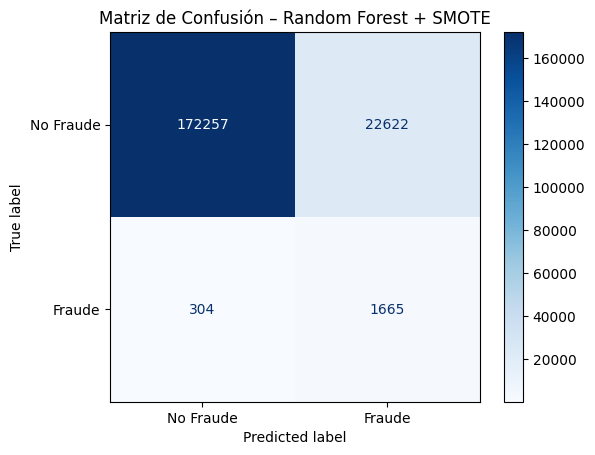

In [8]:
# División Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Entrenamiento (SMOTE se aplica dentro del pipeline)
pipe.fit(X_train, y_train)

# Predicciones finales
y_pred = pipe.predict(X_test)

# Reporte de métricas
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraude", "Fraude"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión – Random Forest + SMOTE")
plt.show()

AUC ROC: 0.897


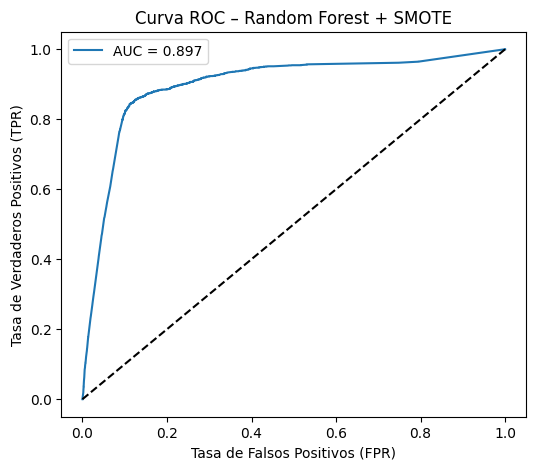

In [9]:
# Probabilidades de clase positiva
y_prob = pipe.predict_proba(X_test)[:, 1]

# Calcular AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC ROC: {auc:.3f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC – Random Forest + SMOTE")
plt.legend()
plt.show()

In [10]:
#Esto es para ver sobreajuste
#El de arriba es para el entrenamiento y el de abajo valores nuevos
#Abajo pierde un poco de presicion pero casi nada 
#Leve sobreajuste
# === Probabilidades de clase positiva (fraude) ===
y_prob_train = pipe.predict_proba(X_train)[:, 1]
y_prob_test = pipe.predict_proba(X_test)[:, 1]

# === Calcular AUC para ambos conjuntos ===
auc_train = roc_auc_score(y_train, y_prob_train)
auc_test = roc_auc_score(y_test, y_prob_test)

print(f"AUC entrenamiento: {auc_train:.3f}")
print(f"AUC test:          {auc_test:.3f}")

AUC entrenamiento: 0.950
AUC test:          0.897


# El modelo RandomForestClassifier, entrenado con balanceo de clases mediante SMOTE y el parámetro class_weight="balanced", mostró un rendimiento altamente competitivo para la detección de fraudes en el dataset analizado.

# Durante la validación cruzada, el modelo mantuvo un F1-score promedio estable, lo que indica consistencia entre los distintos subconjuntos de datos.
# En la evaluación final sobre el conjunto de test, alcanzó un recall del 84.6 %, evidenciando una gran capacidad para detectar la mayoría de los fraudes reales.
# Sin embargo, la precisión (6.9 %) indica la presencia de falsos positivos, lo que es esperable en escenarios con alto desbalance y prioridad en la detección de eventos raros.